In [1]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

In [2]:
# default_exp timecluster

# Detect and explain outliers for high dimensional time series data

> This notebook tries to apply the ideas of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y) for high dimensional time series data. The process consists in the following steps:

1. Normalize the data
2. Extract features from the time series. We will use a rolling window strategy
3. 2D projection of the data through UMAP
4. Link points in the 2d projection to the corresponding sliding window, highlighting not only the time window but also the morst important variables that contributed in the point being in that place of the projection.

In [3]:
# export
import pandas as pd
import seaborn as sns
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Reshape, UpSampling1D
import tensorflow as tf
import umap

Using TensorFlow backend.


In [4]:
#hide
from fastcore import test
from tqdm import tqdm
import matplotlib.pyplot as plt
from pacmel_mining_use_case.load import *

The data that will be used in the rest of the notebook will be stored in the dataframe `df`

In [5]:
!wget -O /home/jovyan/data/input_data.csv https://aida.ii.uam.es/2018-01-15.csv

--2020-03-03 17:09:18--  https://aida.ii.uam.es/2018-01-15.csv
Resolving aida.ii.uam.es (aida.ii.uam.es)... 150.244.57.52
Connecting to aida.ii.uam.es (aida.ii.uam.es)|150.244.57.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42457900 (40M) [text/csv]
Saving to: ‘/home/jovyan/data/input_data.csv’

          /home/jov   0%[                    ]       0  --.-KB/s               

         /home/jovy  55%[==========>         ]  22.38M   112MB/s               

/home/jovyan/data/i 100%[===================>]  40.49M   112MB/s    in 0.4s    

2020-03-03 17:09:18 (112 MB/s) - ‘/home/jovyan/data/input_data.csv’ saved [42457900/42457900]



In [6]:
df = load_numeric_vars('/home/jovyan/data/input_data.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3242: DtypeWarning: Columns (18,19,20,21,22,23,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


##  Sliding window features

Define a continuous multivariate time-series data $D$ of dimension $d$ with $n$ time-steps, $D = X_1,X_2,\dots,X_n$ , where each $X_i = \{x_i^1,\dots,x_i^d\}$ . Let $w$ be the window width, $s$ the stride, and $t$ the start time of a sliding window in the data.

Define a new matrix $Z_k$ where each row is a vector of size $w$ of data extracted from the $k^{th}$ dimension.

\begin{aligned}&Z_k(w,s,t)\\&\quad =\begin{bmatrix} x_{t}^k&\quad x_{t+1}^k&\quad \dots&\quad x_{t+w-1}^k \\ x_{t+s}^k&\quad x_{t+s+1}^k&\quad \dots&\quad x_{t+s+w-1}^k \\ \vdots&\quad \vdots&\quad \ddots&\quad \vdots \\ x_{t+(r-1)s}^k&\quad x_{t+(r-1)s+1}^k&\quad \dots&\quad x_{t+(r-1)s+w-1}^k \end{bmatrix} \end{aligned}

where $r$ is the number of desired rows, and $t+(r-1)s+w-1 \le n$


$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

In [7]:
# parameters
w = 48 # * NOTE: w must be multiple of 12, so that the autoencoder architecture fits correctly
s = 10 # *
t = 0 # NOT SUPPORTED YET

In [8]:
# Parameters
w = 72


In [9]:
test.equals(w % 12, 0)

True

In [10]:
# export
def fslicer(df, w, s=1, padding=False, padding_value=0):
    "Transform a numeric dataframe `df` into slices (sub-dataframes) of `w` rows and the same number of columns than the \
    original dataframe. The distance between each slice is given by the stride `s`. If `padding` is equals to True, \
    the last slices which have less than `w` points are filled with the value marked in the argument \
    `padding_value`. Otherwise, those slices are removed from the result."
    aux = [df.iloc[x:x+w] for x in range(0,len(df), s)]
    if padding:
        with_padding = [x.append(pd.DataFrame(np.full((w - len(x), len(df.columns)), padding_value), columns=df.columns.values)) if len(x) < w else x for x in aux]
    else:
        with_padding = [x for x in aux if len(x)==w]
    return with_padding

In [11]:
df_slices = fslicer(df.drop(['timestamp'], axis=1), w, s)
len(df_slices)

8633

Test the number of slices and the size of each slice

In [12]:
expected_nwindows = (int)((len(df) - w)/s + 1)
expected = [(w, len(df.columns)-1)]*expected_nwindows
actual = [x.shape for x in df_slices]
test.all_equal(expected, actual)

True

## Extract important features from the multivariate time series data through Deep Convolutional Autoencoders


Deep Convolutional Auto Encoders (DCAE) is a powerful method for learning high-level and mid-level abstractions from low-level raw data. It has the ability to extract features from complex and large time-series in an unsupervised manner. This is useful to overcome the complexity of multivariate time-series.

Compared to the conventional auto-encoder, DCAE has fewer parameters than the conventional auto-encoder which means less training time. Also, DCAE uses local information to reconstruct the signal while conventional auto-encoders utilize fully connected layers to globally do the reconstruction. DCAE is an unsupervised model for representation learning which maps inputs into a new representation space. It has two main parts which are the encoding part that is used to project the data into a set of feature spaces and the decoding part that reconstructs the original data. The latent space representation is the space where the data lie in the bottleneck layers.

The loss function of the DCAE is defined as the error between the input and the output. DCAE aims to find a code for each input by minimizing the mean squared error (MSE) between its input (original data) and output (reconstructed data). The MSE is used which assists to minimize the loss; thus, the network is forced to learn a low-dimensional representation of the input.

We will implement the DCAE of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y), whose architecture is shown in the table below:

![](https://i.imgur.com/3EjuAfQ.png)

Note that, in the paper, the input shape is $60 \times 3$, due to multivariate time series has 3 variables and the window size is 60. Generally, the size of the input/output of the autoencoder will depend on the shape of each slice obtained in the previos step. The number of latent features to be discovered is $60$ in the table above, but we can consider this as a free hyperparameter $\delta$.

In [13]:
delta = w # * Number of latent features (by default, it is equals to the window size)

### Create the model

The implementation of the DCAE is done using Keras.

In [14]:
# export
def createDCAE(w, d, delta):
    "Create a Deep Convolutional Autoencoder for multivariate time series of `d` dimensions, \
    sliced with a window size of `w`. The parameter `delta` sets the number of latent features that will be \
    contained in the Dense layer of the network."
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=(w,d), padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPool1D(pool_size=3))
    aux_shape = model.output_shape[1:]
    model.add(Flatten())
    model.add(Dense(units=np.prod(aux_shape), activation='linear', name='latent_features'))
    model.add(Reshape(target_shape=aux_shape))
    model.add(Conv1D(filters=12, kernel_size=5, activation='relu', padding='same'))
    model.add(UpSampling1D(size=3))
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu', padding='same'))
    model.add(UpSampling1D(size=2))
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu', padding='same'))
    model.add(UpSampling1D(size=2))
    model.add(Conv1D(filters=d, kernel_size=10, activation='linear', padding='same'))
    return model

In [15]:
m = createDCAE(w, len(df_slices[0].columns), delta)
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 72, 64)            24384     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 32)            10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 12)            1932      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 6, 12)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)               

The sliced data must be converted to a numpy array with shape $(n \times w \times d)$, where $n$ is the length of the time series, $w$ is the window size and $d$ is the number of dimensions in the time series. 

In [16]:
# export
def slices2array(slices):
    "`slices` is a list of dataframes, each of them containing an slice of a multivariate time series."
    return np.rollaxis(np.dstack([x.values for x in slices]), -1)

In [17]:
input_data = slices2array(df_slices)

In [18]:
test.equals(input_data.shape, (len(df_slices), len(df_slices[0]), len(df_slices[0].columns)))

True

To train the model, we use the same hyperparameters (loss function, optimizer, batch size) than in the paper.

In [19]:
loss = 'mean_squared_error'
opt = 'adam'
bs = 100
epochs = 5
val = .2

In [20]:
m.compile(loss=loss, optimizer=opt)

In [21]:
history = m.fit(x=input_data, y=input_data, batch_size=bs, validation_split=val, epochs=epochs)

Train on 6906 samples, validate on 1727 samples
Epoch 1/5


 100/6906 [..............................] - ETA: 26s - loss: 0.2125

 200/6906 [..............................] - ETA: 14s - loss: 0.1979

 400/6906 [>.............................] - ETA: 8s - loss: 0.1676 

 600/6906 [=>............................] - ETA: 6s - loss: 0.1408

 800/6906 [==>...........................] - ETA: 4s - loss: 0.1188

1000/6906 [===>..........................] - ETA: 4s - loss: 0.1050

1200/6906 [====>.........................] - ETA: 3s - loss: 0.0954

1400/6906 [=====>........................] - ETA: 3s - loss: 0.0877

1600/6906 [=====>........................] - ETA: 2s - loss: 0.0814

1800/6906 [======>.......................] - ETA: 2s - loss: 0.0766

2000/6906 [=======>......................] - ETA: 2s - loss: 0.0722

2200/6906 [========>.....................] - ETA: 2s - loss: 0.0688

2400/6906 [=========>....................] - ETA: 2s - loss: 0.0659

2600/6906 [==========>...................] - ETA: 2s - loss: 0.0634

2800/6906 [===========>..................] - ETA: 1s - loss: 0.0613

3000/6906 [============>.................] - ETA: 1s - loss: 0.0593

3200/6906 [============>.................] - ETA: 1s - loss: 0.0575

3400/6906 [=============>................] - ETA: 1s - loss: 0.0560

3600/6906 [==============>...............] - ETA: 1s - loss: 0.0546

3800/6906 [===============>..............] - ETA: 1s - loss: 0.0533

4000/6906 [================>.............] - ETA: 1s - loss: 0.0521

4200/6906 [=================>............] - ETA: 1s - loss: 0.0512

4400/6906 [==================>...........] - ETA: 1s - loss: 0.0501

4600/6906 [==================>...........] - ETA: 0s - loss: 0.0491

4800/6906 [===================>..........] - ETA: 0s - loss: 0.0482

5000/6906 [====================>.........] - ETA: 0s - loss: 0.0474

5200/6906 [=====================>........] - ETA: 0s - loss: 0.0465

5400/6906 [======================>.......] - ETA: 0s - loss: 0.0456

5600/6906 [=======================>......] - ETA: 0s - loss: 0.0448

5800/6906 [========================>.....] - ETA: 0s - loss: 0.0440

6000/6906 [=========================>....] - ETA: 0s - loss: 0.0433

6200/6906 [=========================>....] - ETA: 0s - loss: 0.0426

6400/6906 [==========================>...] - ETA: 0s - loss: 0.0419

6600/6906 [===========================>..] - ETA: 0s - loss: 0.0413

6800/6906 [============================>.] - ETA: 0s - loss: 0.0407

6906/6906 [==============================] - 3s 432us/step - loss: 0.0404 - val_loss: 0.0162


Epoch 2/5
 100/6906 [..............................] - ETA: 2s - loss: 0.0193

 300/6906 [>.............................] - ETA: 2s - loss: 0.0201

 500/6906 [=>............................] - ETA: 2s - loss: 0.0199

 700/6906 [==>...........................] - ETA: 2s - loss: 0.0195

 900/6906 [==>...........................] - ETA: 2s - loss: 0.0195

1100/6906 [===>..........................] - ETA: 1s - loss: 0.0194

1300/6906 [====>.........................] - ETA: 1s - loss: 0.0192

1500/6906 [=====>........................] - ETA: 1s - loss: 0.0189

1700/6906 [======>.......................] - ETA: 1s - loss: 0.0185

1900/6906 [=======>......................] - ETA: 1s - loss: 0.0183

2100/6906 [========>.....................] - ETA: 1s - loss: 0.0180

2300/6906 [========>.....................] - ETA: 1s - loss: 0.0177

2500/6906 [=========>....................] - ETA: 1s - loss: 0.0173

2700/6906 [==========>...................] - ETA: 1s - loss: 0.0170

2900/6906 [===========>..................] - ETA: 1s - loss: 0.0167

3100/6906 [============>.................] - ETA: 1s - loss: 0.0165

3300/6906 [=============>................] - ETA: 1s - loss: 0.0162

3500/6906 [==============>...............] - ETA: 1s - loss: 0.0159

3700/6906 [===============>..............] - ETA: 1s - loss: 0.0158

3900/6906 [===============>..............] - ETA: 1s - loss: 0.0156

4100/6906 [================>.............] - ETA: 0s - loss: 0.0155

4300/6906 [=================>............] - ETA: 0s - loss: 0.0154

4500/6906 [==================>...........] - ETA: 0s - loss: 0.0153

4700/6906 [===================>..........] - ETA: 0s - loss: 0.0152

4900/6906 [====================>.........] - ETA: 0s - loss: 0.0150

5100/6906 [=====================>........] - ETA: 0s - loss: 0.0149

5300/6906 [======================>.......] - ETA: 0s - loss: 0.0148

5500/6906 [======================>.......] - ETA: 0s - loss: 0.0147

5700/6906 [=======================>......] - ETA: 0s - loss: 0.0146

5900/6906 [========================>.....] - ETA: 0s - loss: 0.0145

6100/6906 [=========================>....] - ETA: 0s - loss: 0.0144

6300/6906 [==========================>...] - ETA: 0s - loss: 0.0143

6500/6906 [===========================>..] - ETA: 0s - loss: 0.0142

6700/6906 [============================>.] - ETA: 0s - loss: 0.0141

6900/6906 [============================>.] - ETA: 0s - loss: 0.0141

6906/6906 [==============================] - 3s 390us/step - loss: 0.0141 - val_loss: 0.0115


Epoch 3/5
 100/6906 [..............................] - ETA: 2s - loss: 0.0122

 300/6906 [>.............................] - ETA: 2s - loss: 0.0118

 500/6906 [=>............................] - ETA: 2s - loss: 0.0120

 700/6906 [==>...........................] - ETA: 2s - loss: 0.0119

 900/6906 [==>...........................] - ETA: 2s - loss: 0.0116

1100/6906 [===>..........................] - ETA: 2s - loss: 0.0116

1300/6906 [====>.........................] - ETA: 2s - loss: 0.0116

1500/6906 [=====>........................] - ETA: 2s - loss: 0.0115

1700/6906 [======>.......................] - ETA: 1s - loss: 0.0115

1900/6906 [=======>......................] - ETA: 1s - loss: 0.0114

2100/6906 [========>.....................] - ETA: 1s - loss: 0.0115

2300/6906 [========>.....................] - ETA: 1s - loss: 0.0113

2500/6906 [=========>....................] - ETA: 1s - loss: 0.0113

2700/6906 [==========>...................] - ETA: 1s - loss: 0.0113

2900/6906 [===========>..................] - ETA: 1s - loss: 0.0113

3100/6906 [============>.................] - ETA: 1s - loss: 0.0112

3300/6906 [=============>................] - ETA: 1s - loss: 0.0112

3500/6906 [==============>...............] - ETA: 1s - loss: 0.0111

3700/6906 [===============>..............] - ETA: 1s - loss: 0.0111

3900/6906 [===============>..............] - ETA: 1s - loss: 0.0110

4100/6906 [================>.............] - ETA: 0s - loss: 0.0110

4300/6906 [=================>............] - ETA: 0s - loss: 0.0109

4500/6906 [==================>...........] - ETA: 0s - loss: 0.0109

4700/6906 [===================>..........] - ETA: 0s - loss: 0.0108

4900/6906 [====================>.........] - ETA: 0s - loss: 0.0107

5100/6906 [=====================>........] - ETA: 0s - loss: 0.0107

5300/6906 [======================>.......] - ETA: 0s - loss: 0.0106

5500/6906 [======================>.......] - ETA: 0s - loss: 0.0105

5700/6906 [=======================>......] - ETA: 0s - loss: 0.0105

5900/6906 [========================>.....] - ETA: 0s - loss: 0.0105

6100/6906 [=========================>....] - ETA: 0s - loss: 0.0104

6300/6906 [==========================>...] - ETA: 0s - loss: 0.0103

6500/6906 [===========================>..] - ETA: 0s - loss: 0.0102

6700/6906 [============================>.] - ETA: 0s - loss: 0.0101

6900/6906 [============================>.] - ETA: 0s - loss: 0.0101

6906/6906 [==============================] - 3s 391us/step - loss: 0.0101 - val_loss: 0.0076


Epoch 4/5
 100/6906 [..............................] - ETA: 1s - loss: 0.0079

 300/6906 [>.............................] - ETA: 1s - loss: 0.0083

 500/6906 [=>............................] - ETA: 1s - loss: 0.0082

 700/6906 [==>...........................] - ETA: 1s - loss: 0.0078

 900/6906 [==>...........................] - ETA: 1s - loss: 0.0076

1100/6906 [===>..........................] - ETA: 1s - loss: 0.0074

1300/6906 [====>.........................] - ETA: 1s - loss: 0.0075

1500/6906 [=====>........................] - ETA: 1s - loss: 0.0075

1700/6906 [======>.......................] - ETA: 1s - loss: 0.0074

1900/6906 [=======>......................] - ETA: 1s - loss: 0.0073

2100/6906 [========>.....................] - ETA: 1s - loss: 0.0072

2300/6906 [========>.....................] - ETA: 1s - loss: 0.0072

2500/6906 [=========>....................] - ETA: 1s - loss: 0.0071

2700/6906 [==========>...................] - ETA: 1s - loss: 0.0070

2900/6906 [===========>..................] - ETA: 1s - loss: 0.0069

3100/6906 [============>.................] - ETA: 1s - loss: 0.0068

3300/6906 [=============>................] - ETA: 1s - loss: 0.0068

3500/6906 [==============>...............] - ETA: 1s - loss: 0.0068

3700/6906 [===============>..............] - ETA: 0s - loss: 0.0068

3900/6906 [===============>..............] - ETA: 0s - loss: 0.0067

4100/6906 [================>.............] - ETA: 0s - loss: 0.0067

4300/6906 [=================>............] - ETA: 0s - loss: 0.0067

4500/6906 [==================>...........] - ETA: 0s - loss: 0.0067

4700/6906 [===================>..........] - ETA: 0s - loss: 0.0066

4900/6906 [====================>.........] - ETA: 0s - loss: 0.0066

5100/6906 [=====================>........] - ETA: 0s - loss: 0.0066

5300/6906 [======================>.......] - ETA: 0s - loss: 0.0066

5500/6906 [======================>.......] - ETA: 0s - loss: 0.0066

5700/6906 [=======================>......] - ETA: 0s - loss: 0.0065

5900/6906 [========================>.....] - ETA: 0s - loss: 0.0065

6100/6906 [=========================>....] - ETA: 0s - loss: 0.0065

6300/6906 [==========================>...] - ETA: 0s - loss: 0.0064

6500/6906 [===========================>..] - ETA: 0s - loss: 0.0064

6700/6906 [============================>.] - ETA: 0s - loss: 0.0064

6900/6906 [============================>.] - ETA: 0s - loss: 0.0064

6906/6906 [==============================] - 2s 361us/step - loss: 0.0064 - val_loss: 0.0065


Epoch 5/5
 100/6906 [..............................] - ETA: 5s - loss: 0.0072

 200/6906 [..............................] - ETA: 4s - loss: 0.0061

 400/6906 [>.............................] - ETA: 3s - loss: 0.0059

 600/6906 [=>............................] - ETA: 3s - loss: 0.0057

 800/6906 [==>...........................] - ETA: 2s - loss: 0.0058

1000/6906 [===>..........................] - ETA: 2s - loss: 0.0056

1200/6906 [====>.........................] - ETA: 2s - loss: 0.0057

1400/6906 [=====>........................] - ETA: 2s - loss: 0.0056

1600/6906 [=====>........................] - ETA: 2s - loss: 0.0056

1800/6906 [======>.......................] - ETA: 2s - loss: 0.0056

2000/6906 [=======>......................] - ETA: 2s - loss: 0.0056

2200/6906 [========>.....................] - ETA: 1s - loss: 0.0056

2400/6906 [=========>....................] - ETA: 1s - loss: 0.0056

2600/6906 [==========>...................] - ETA: 1s - loss: 0.0055

2800/6906 [===========>..................] - ETA: 1s - loss: 0.0056

3000/6906 [============>.................] - ETA: 1s - loss: 0.0055

3200/6906 [============>.................] - ETA: 1s - loss: 0.0055

3400/6906 [=============>................] - ETA: 1s - loss: 0.0056

3600/6906 [==============>...............] - ETA: 1s - loss: 0.0055

3800/6906 [===============>..............] - ETA: 1s - loss: 0.0055

4000/6906 [================>.............] - ETA: 1s - loss: 0.0055

4200/6906 [=================>............] - ETA: 1s - loss: 0.0055

4400/6906 [==================>...........] - ETA: 1s - loss: 0.0055

4600/6906 [==================>...........] - ETA: 0s - loss: 0.0055

4800/6906 [===================>..........] - ETA: 0s - loss: 0.0055

5000/6906 [====================>.........] - ETA: 0s - loss: 0.0054

5200/6906 [=====================>........] - ETA: 0s - loss: 0.0054

5400/6906 [======================>.......] - ETA: 0s - loss: 0.0053

5600/6906 [=======================>......] - ETA: 0s - loss: 0.0053

5800/6906 [========================>.....] - ETA: 0s - loss: 0.0053

6000/6906 [=========================>....] - ETA: 0s - loss: 0.0053

6200/6906 [=========================>....] - ETA: 0s - loss: 0.0053

6400/6906 [==========================>...] - ETA: 0s - loss: 0.0052

6600/6906 [===========================>..] - ETA: 0s - loss: 0.0052

6800/6906 [============================>.] - ETA: 0s - loss: 0.0052

6906/6906 [==============================] - 3s 441us/step - loss: 0.0052 - val_loss: 0.0063


### Getting the latent variables from the trained model

Once the model is trained, we are interested in the information contained in the **Dense** layer for each slice of data. To do that, we have to call the `predict` function on an intermediate model that gets the output of the intermediate layer.

In [22]:
layer_latent_output = m.get_layer('latent_features').output

In [23]:
intermediate_model = Model(inputs=m.input, outputs=layer_latent_output)

In [24]:
intermediate_prediction = intermediate_model.predict(input_data)

## Dimensionality reduction using UMAP

We use DR techniques to provide an alternative view for users to visually analyze and explore the time-series data. The algorithm UMAP shows its high competitiveness compared to t-SNE. t-SNE suffers from some limitations such as loss of large-scale information (the inter-cluster relationships). UMAP has a faster runtime and provides better scaling which helps to gain a meaningful organization of clusters, outliers and the preservation of continuums compared to t-SNE

For this part of the implementation, the package [umap-learn](https://github.com/lmcinnes/umap) is used. The input of the algoritm is the $n \times \delta$ that contains, for each slice of the time series, the corresponding $\delta$ latent features given by the DCAE.

The hyperparameters of UMAP are given randomly here. In the future, an app will be created to play with them.

In [25]:
n_neighbours = 15
min_dist = 0.1
metric = 'euclidean'

In [26]:
embeddings = umap.UMAP().fit_transform(intermediate_prediction)

/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))


/opt/conda/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


## 2D Visualization 

While the connected scatter plot is a simple visualization technique, it has very specific functions in our approach. Every sliding window is represented as a dot in the plot after the projection process (Fig. 4C, D of the paper). Before labeling, all points have the same color and transparency, and when they are concentrated in one area, the densities are accumulated. Lines are used to connect consecutive points preserving the temporal ordering of the data and allowing the user to see temporal connections (Fig. 4B of the paper). Thus, the point is linked to the previous point (inner) and to the posterior point (outer) as an indication of the flow of time.

In [27]:
df_embeddings = pd.DataFrame(embeddings, columns = ['x1', 'x2'])

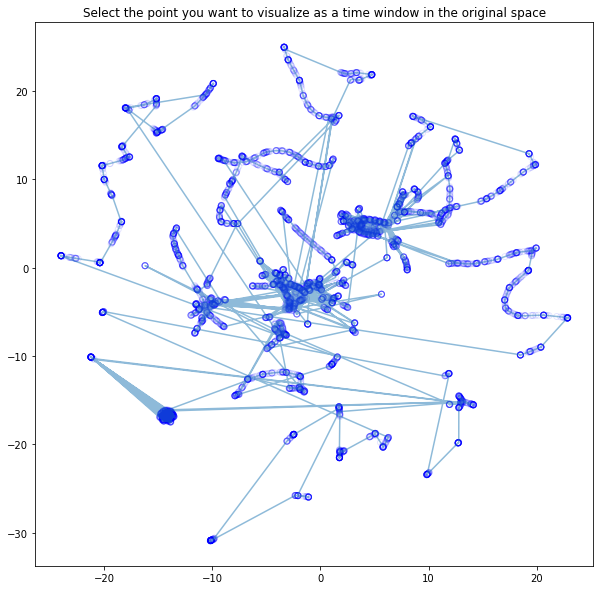

In [28]:
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(df_embeddings['x1'], df_embeddings['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
ax.plot(df_embeddings['x1'], df_embeddings['x2'], alpha=0.5, picker=1)
ax.set_title('Select the point you want to visualize as a time window in the original space')

selected_indices = None
selected_points = None

def onpick(event):
    global selected_points
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    global selected_indices
    selected_indices = event.ind
    selected_points = tuple(zip(xdata[selected_indices], ydata[selected_indices]))
    print('onpick points (first):', selected_points[0])

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()


## Linking back points of the 2D projection to the original time series

The variable `selected_points` and `ind` contain an array of the points and indices selected in the previous 2D projection. We will take the first of them (there can be many selected points with just one click), and use its index to get the corresponding time window of the original space.

In [29]:
selected_window = input_data[df_embeddings.sample(n=1).index][0] if selected_indices is None else input_data[selected_indices[0]]
selected_window

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Visualizing all the variables in the time window (default)

In [30]:
df_output = pd.DataFrame(selected_window, columns=df.columns[:-1])
df_output['timestamp'] = df['timestamp']

In [31]:
df_output_tidy = pd.melt(df_output, id_vars=['timestamp'], value_vars=df_output.columns[:-1])
df_output_tidy.head()

,timestamp,variable,value
0,2018-01-15 00:00:00,Prąd silnika organu lewego,0.0
1,2018-01-15 00:00:01,Prąd silnika organu lewego,0.0
2,2018-01-15 00:00:02,Prąd silnika organu lewego,0.0
3,2018-01-15 00:00:03,Prąd silnika organu lewego,0.0
4,2018-01-15 00:00:04,Prąd silnika organu lewego,0.0


In [32]:
#hide
from pandas.plotting import register_matplotlib_converters

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


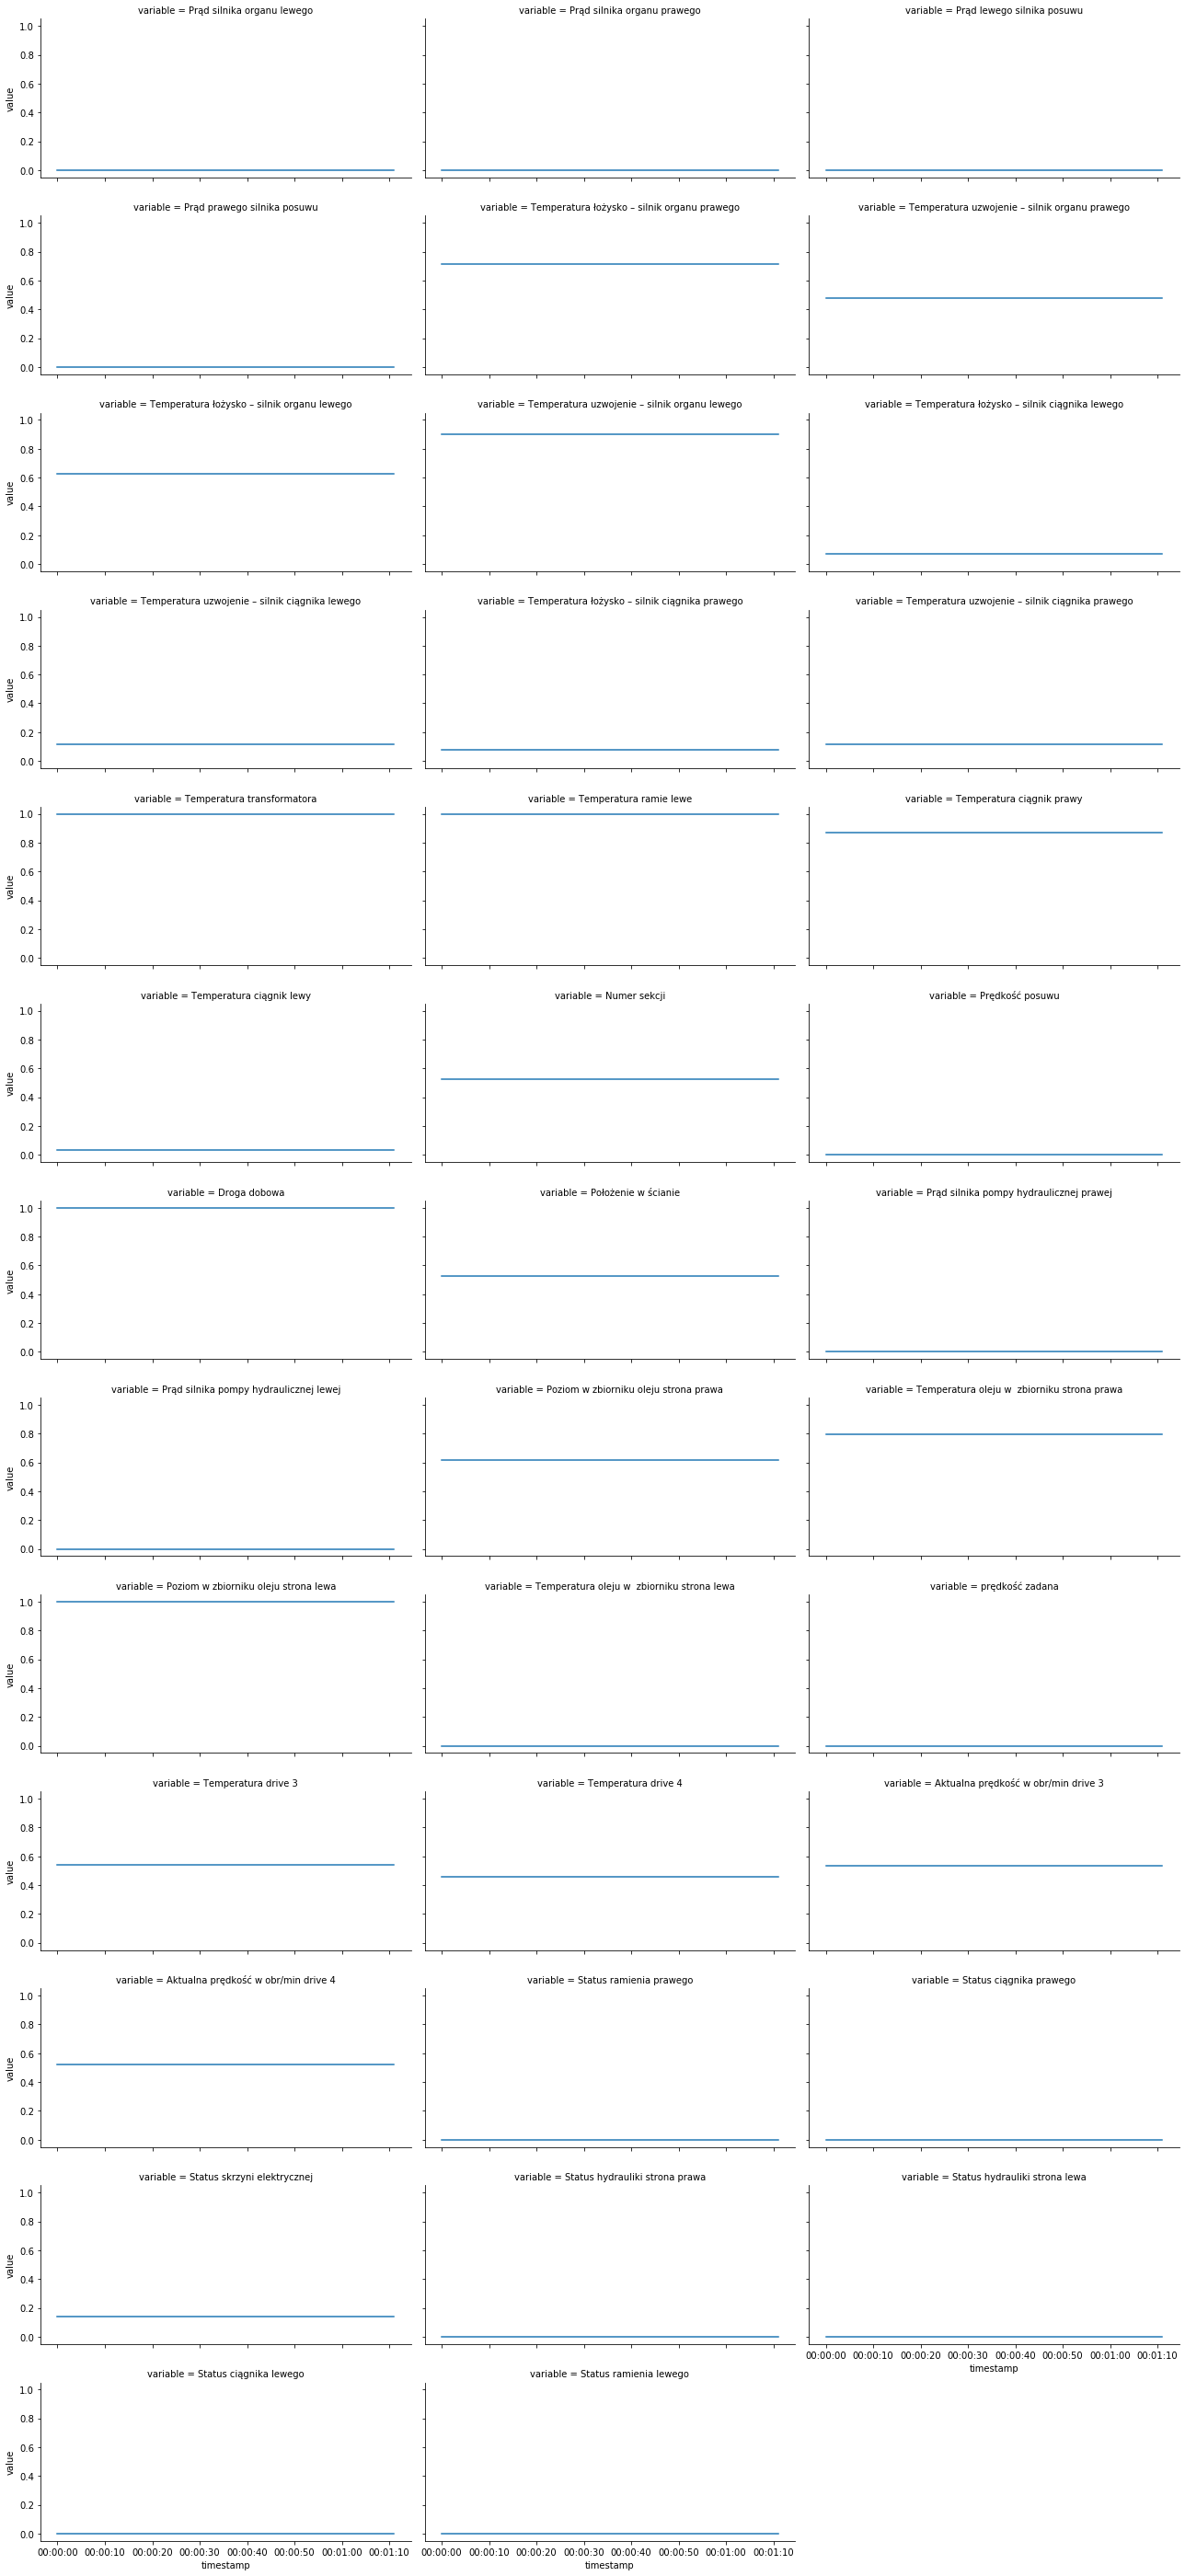

In [33]:
%matplotlib inline
g = sns.FacetGrid(df_output_tidy, col="variable", col_wrap=3, aspect=2)
g = g.map(plt.plot, "timestamp", "value")

### Contribution: Visualize only the most relevant variables